# Analysing Fitness Data 

## 1. Obtain and review raw data
<p>The Data is of 7 years RunnKeeper App Data From 2013 - 2018</p>
<p><img src="https://assets.datacamp.com/production/project_727/img/runner_in_blue.jpg" alt="Runner in blue" title="Explore world, explore your data!"></p>


In [12]:
# standard libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext lab_black
%matplotlib inline

# warnings
import warnings

plt.style.use("ggplot")
warnings.filterwarnings(
    action="ignore",
    module="matplotlib.figure",
    category=UserWarning,
    message=(
        "This figure includes Axes that are not compatible with tight_layout, so results might be incorrect."
    ),
)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [8]:
runkeeper_file = "datasets/cardioActivities.csv"
# load the data
df_activities = pd.read_csv(runkeeper_file, parse_dates=["Date"], index_col="Date")

# random 3 samples
display(df_activities.sample(3))

# summary
display(df_activities.info())

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2017-01-30 18:43:33,dcf483e9-421e-42b6-b116-884c794f5366,Running,NaN,6.98,37:28,5:22,11.18,497.0,66,143.0,NaN,TomTom MySports Watch,2017-01-30-184333.gpx
2018-02-15 19:11:33,dd258b46-8c3b-429a-9884-c38d29f1a77d,Running,NaN,10.27,1:00:19,5:52,10.22,730.0,174,146.0,NaN,TomTom MySports Watch,2018-02-15-191133.gpx
2018-07-03 18:00:05,e91eba7e-dd4c-4ae4-8909-c35dc6e2debb,Running,NaN,18.75,1:41:30,5:25,11.08,1332.0,300,139.0,NaN,TomTom MySports Watch,2018-07-03-180005.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               508 non-null    object 
 1   Type                      508 non-null    object 
 2   Route Name                1 non-null      object 
 3   Distance (km)             508 non-null    float64
 4   Duration                  508 non-null    object 
 5   Average Pace              508 non-null    object 
 6   Average Speed (km/h)      508 non-null    float64
 7   Calories Burned           508 non-null    float64
 8   Climb (m)                 508 non-null    int64  
 9   Average Heart Rate (bpm)  294 non-null    float64
 10  Friend's Tagged           0 non-null      float64
 11  Notes                     231 non-null    object 
 12  GPX File                  504 non-null    object 
dtypes: float64(5), int64(1), obj

None

## 2. Data preprocessing
<p>Luckily, the column names Runkeeper provides are informative, and we don't need to rename any columns.</p>
<p>But, we do notice missing values using the <code>info()</code> method. What are the reasons for these missing values? It depends. Some heart rate information is missing because the user always not use a cardio sensor. In the case of the <code>Notes</code> column, it is an optional field that user sometimes left blank. Also, user used the <code>Route Name</code> column once, and never used the <code>Friend's Tagged</code> column.</p>
<p>We'll fill in missing values in the heart rate column to avoid misleading results later, but right now, our first data preprocessing steps will be to:</p>
<ul>
<li>Remove columns not useful for our analysis.</li>
<li>Replace the "Other" activity type to "Unicycling" because that was always the "Other" activity.</li>
<li>Count missing values.</li>
</ul>

In [9]:
# columns to be removed
cols_to_drop = [
    "Friend's Tagged",
    "Route Name",
    "GPX File",
    "Activity Id",
    "Calories Burned",
    "Notes",
]

# drop the unnessary columns
df_activities = df_activities.drop(cols_to_drop, axis=1)

# Count types of training activities
display(df_activities.Type.value_counts())

# Renaming  'Other' type to 'Unicycling'
df_activities["Type"] = df_activities.Type.replace("Other", "Unicycling")

# count of the missing values
df_activities.isna().sum()

Type
Running    459
Cycling     29
Walking     18
Other        2
Name: count, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

## 3. Dealing with missing values
<p>As we can see from the last output, there are 214 missing entries for my average heart rate.</p>
<p>We can't go back in time to get those data, but we can fill in the missing values with an average value. This process is called <em>mean imputation</em>. When imputing the mean to fill in missing data, we need to consider that the average heart rate varies for different activities (e.g., walking vs. running). We'll filter the DataFrames by activity type (<code>Type</code>) and calculate each activity's mean heart rate, then fill in the missing values with those means.</p>

In [11]:
# Calculating sample means for heart rate for each training activity type
avg_hr_run = df_activities[df_activities["Type"] == "Running"][
    "Average Heart Rate (bpm)"
].mean()
avg_hr_cycle = df_activities[df_activities["Type"] == "Cycling"][
    "Average Heart Rate (bpm)"
].mean()

# Split whole DataFrame into several, specific for different activities
df_run = df_activities[df_activities["Type"] == "Running"].copy()
df_walk = df_activities[df_activities["Type"] == "Walking"].copy()
df_cycle = df_activities[df_activities["Type"] == "Cycling"].copy()

# Filling missing values with counted means
df_walk["Average Heart Rate (bpm)"].fillna(110, inplace=True)
df_run["Average Heart Rate (bpm)"].fillna(int(avg_hr_run), inplace=True)
df_cycle["Average Heart Rate (bpm)"].fillna(int(avg_hr_cycle), inplace=True)

# Count missing values for each column in running data
df_run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

## 4. Plot running data
<p>Now we can create our first plot! As we found earlier, most of the activities in my data were running (459 of them to be exact). There are only 29, 18, and two instances for cycling, walking, and unicycling, respectively. So now, let's plot the different running metrics.</p>
<p>An excellent first visualization is a figure with four subplots, one for each running metric (each numerical column). Each subplot will have a different y-axis, which is explained in each legend. The x-axis, <code>Date</code>, is shared among all subplots.</p>

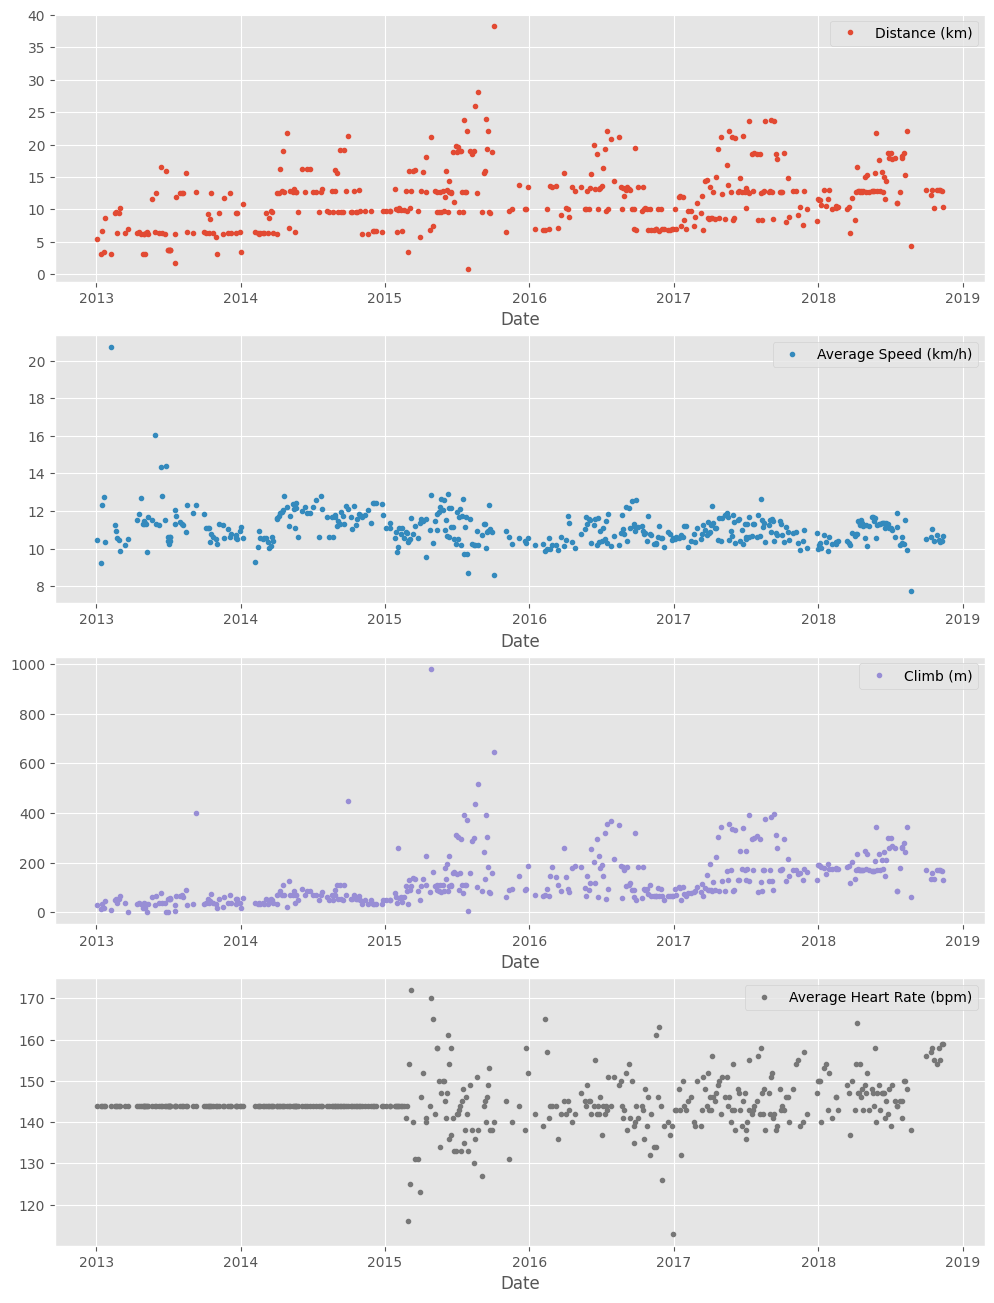

In [13]:
# Preparing data subsetting period from 2013 till 2018
runs_subset_2013_2018 = df_run.sort_index().loc["2013-01-01":"2018-12-31"]

# Create, plot and customize in one step
runs_subset_2013_2018.plot(
    subplots=True,
    sharex=False,
    figsize=(12, 16),
    linestyle="none",
    marker="o",
    markersize=3,
)

plt.show()

## 5. Running statistics
<p>No doubt, running helps people stay mentally and physically healthy and productive at any age. And it is great fun! When runners talk to each other about their hobby, we not only discuss our results, but we also discuss different training strategies. </p>
<p>You'll know you're with a group of runners if you commonly hear questions like:</p>
<ul>
<li>What is your average distance?</li>
<li>How fast do you run?</li>
<li>Do you measure your heart rate?</li>
<li>How often do you train?</li>
</ul>
<p>Let's find the answers to these questions in the data. If you look back at plots in Task 4, you can see the answer to, <em>Do the user measure heart rate?</em> Before 2015: no. To look at the averages, let's only use the data from 2015 through 2018.</p>
<p>  used <code>resample()</code>to group the time series data by a sampling period and apply several methods to each sampling period. In our case, we resample annually and weekly.</p>

In [15]:
# Prepare running data for the last 4 years
runs_subset_2015_2018 = runs_subset_2013_2018[
    ["Distance (km)", "Average Speed (km/h)", "Climb (m)", "Average Heart Rate (bpm)"]
].loc["2015-01-01":"2018-12-31"]
runs_subset_2015_2018.resample("A").mean()

# # Calculate annual statistics
print("How my average run looks in last 4 years:")
display(runs_subset_2015_2018.resample("A").mean())

# Calculate weekly statistics
print("Weekly averages of last 4 years:")
display(runs_subset_2015_2018.resample("W").mean().mean())

# # Mean weekly counts
weekly_counts_average = (
    runs_subset_2015_2018["Distance (km)"].resample("W").count().mean()
)
print("How many trainings per week User had on average:", weekly_counts_average)

How my average run looks in last 4 years:


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2015-12-31,13.602805,10.998902,160.170732,143.353659
2016-12-31,11.411667,10.837778,133.194444,143.388889
2017-12-31,12.935176,10.959059,169.376471,145.247059
2018-12-31,13.339063,10.777969,191.218750,148.125000


Weekly averages of last 4 years:


Distance (km)                12.518176
Average Speed (km/h)         10.835473
Climb (m)                   158.325444
Average Heart Rate (bpm)    144.801775
dtype: float64

How many trainings per week User had on average: 1.5


## 6. Visualization with averages
<p>Let's plot the long term averages of user distance run and  heart rate with their raw data to visually compare the averages to each training session. Again, we use the data from 2015 through 2018.</p>
<p>In this task, we will use <code>matplotlib</code> functionality for plot creation and customization.</p>

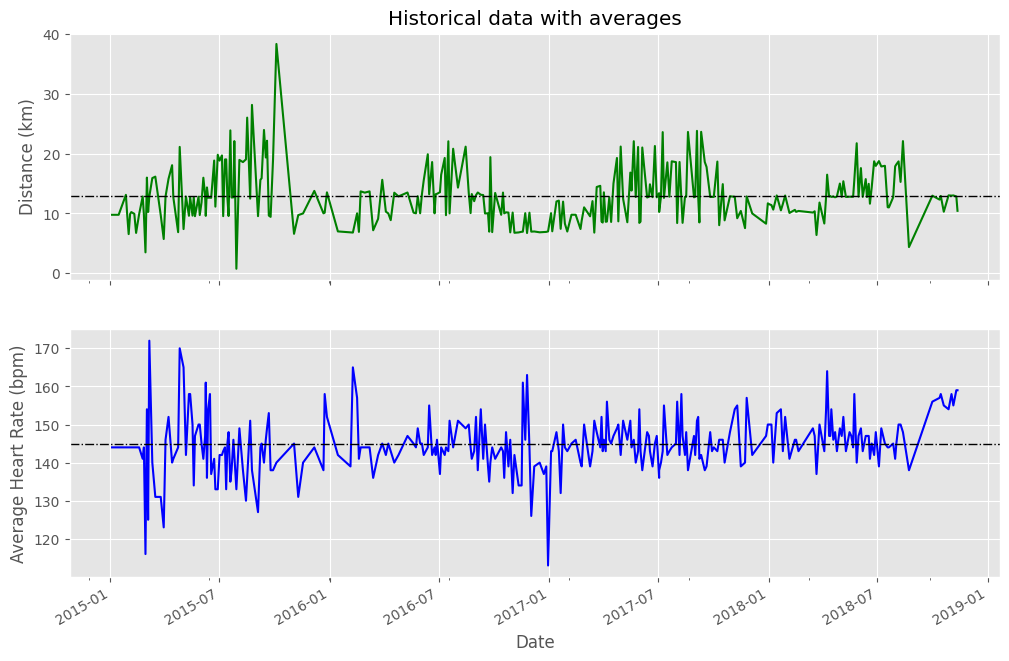

In [17]:
# Prepare data
runs_distance = runs_subset_2015_2018["Distance (km)"]
runs_hr = runs_subset_2015_2018["Average Heart Rate (bpm)"]

# subplots
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

# Plot and customize first subplot
ax1.set(ylabel="Distance (km)", title="Historical data with averages")
runs_distance.plot(ax=ax1, color="green")
ax1.axhline(runs_distance.mean(), color="black", linewidth=1, linestyle="-.")


# Plot and customize second subplot
runs_hr.plot(ax=ax2, color="blue")
ax2.set(xlabel="Date", ylabel="Average Heart Rate (bpm)")
ax2.axhline(runs_hr.mean(), color="black", lw=1, ls="-.")

# Show plot
plt.show()

## 7. Did User reach my goals?
<p>To motivate  to run regularly, User set a target goal of running 1000 km per year. Let's visualize  annual running distance (km) from 2013 through 2018 to see if user reached his goal each year. Only stars in the green region indicate success.</p>

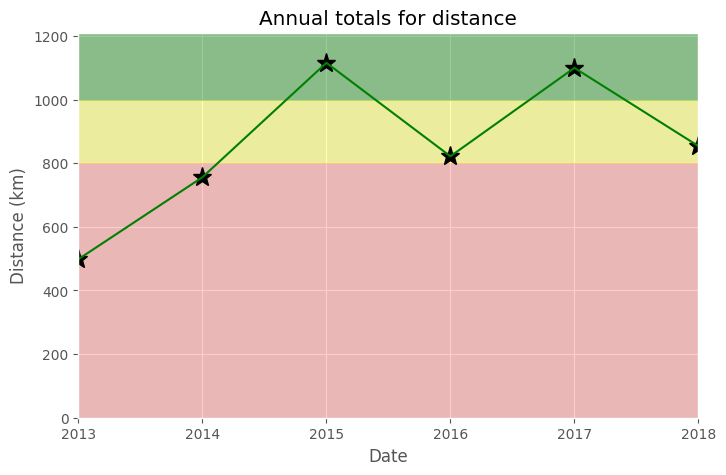

In [19]:
# Prepare data
df_run_dist_annual = runs_subset_2013_2018["Distance (km)"].resample("A").sum()

# Create plot
fig = plt.figure(figsize=(8, 5))

# Plot and customize
ax = df_run_dist_annual.plot(marker="*", markersize=14, linewidth=0, color="black")
ax.set(
    ylim=[0, 1210],
    xlim=["2012", "2019"],
    ylabel="Distance (km)",
    xlabel="Years",
    title="Annual totals for distance",
)

ax.axhspan(1000, 1210, color="green", alpha=0.4)
ax.axhspan(800, 1000, color="yellow", alpha=0.3)
ax.axhspan(0, 800, color="red", alpha=0.2)
df_run_dist_annual.plot(color="green")

# Show plot
plt.show()

## 8. Is user progressing?
<p>Let's dive a little deeper into the data to answer a tricky question: is user progressing in terms of his running skills? </p>
<p>To answer this question, we'll decompose his weekly distance run and visually compare it to the raw data. A red trend line will represent the weekly distance run.</p>
<p>used  <code>statsmodels</code> library to decompose the weekly trend.</p>

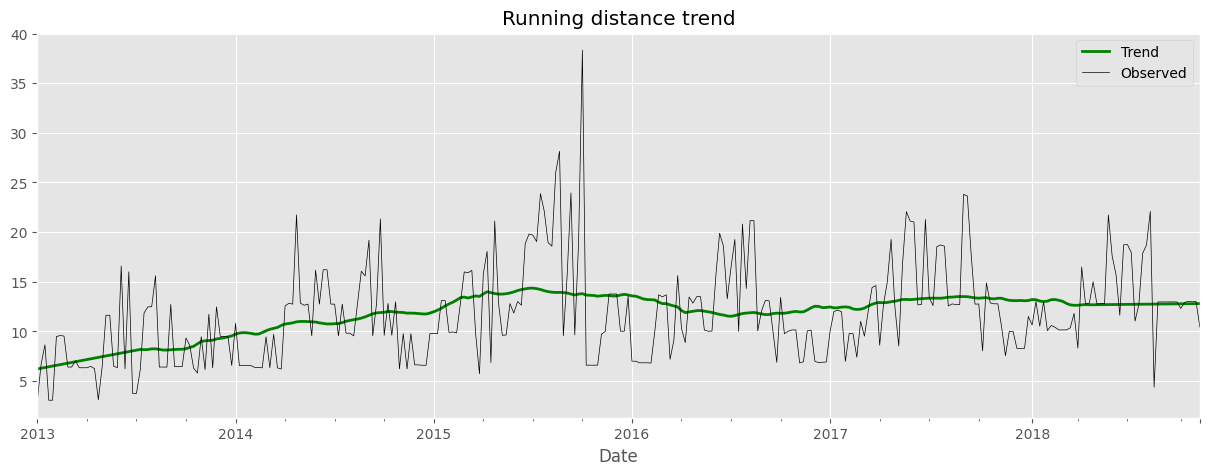

In [20]:
# Import required library
import statsmodels.api as sm

# Prepare data
df_run_dist_wkly = runs_subset_2013_2018["Distance (km)"].resample("W").bfill()
decomposed = sm.tsa.seasonal_decompose(df_run_dist_wkly, extrapolate_trend=1)

# Create plot
fig = plt.figure(figsize=(15, 5))

# Plot and customize
ax = decomposed.trend.plot(label="Trend", linewidth=2, color="green")
ax = decomposed.observed.plot(label="Observed", linewidth=0.5, color="black")

ax.legend()
ax.set_title("Running distance trend")

# Show plot
plt.show()

## 9. Training intensity
<p>Heart rate is a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum.</p>
<p>created a distribution plot of user heart rate data by training intensity. It will be a visual presentation for the number of activities from predefined training zones. </p>

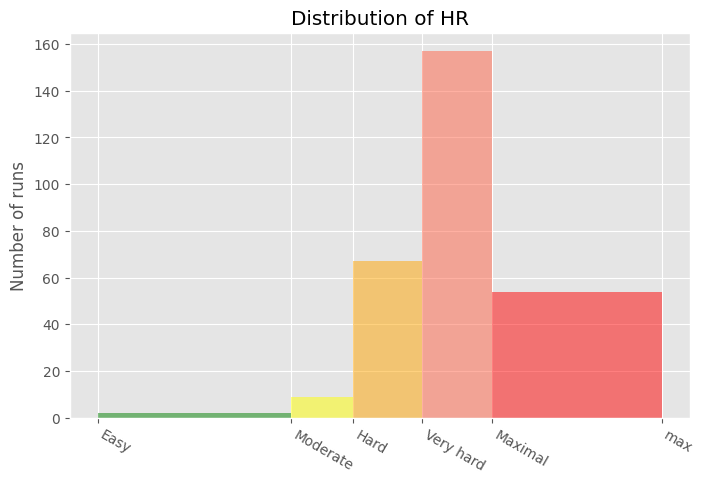

In [22]:
# Prepare data
hr_zones = [100, 125, 133, 142, 151, 173]
zone_names = [
    "Easy",
    "Moderate",
    "Hard",
    "Very hard",
    "Maximal",
    "max",
]  # max used as xticks expects 6 lables and we are one short
zone_colors = ["green", "yellow", "orange", "tomato", "red", "blue"]
df_run_hr_all = df_run.sort_index().loc["2015-03-01":"2018-12-01"][
    "Average Heart Rate (bpm)"
]

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot and customize
n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])

ax.set(title="Distribution of HR", ylabel="Number of runs")
ax.xaxis.set(ticks=hr_zones)
ax.set_xticklabels(labels=zone_names, rotation=-30, ha="left")

# Show plot
plt.show()

## 10. Detailed summary report
<p>With all this data cleaning, analysis, and visualization, let's create detailed summary tables of user training. </p>
<p>To do this, I created two tables. The first table will be a summary of the distance (km) and climb (m) variables for each training activity. The second table will list the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.</p>

In [23]:
# Concatenating three DataFrames
df_run_walk_cycle = pd.concat([df_run, df_walk, df_cycle]).sort_index(ascending=False)

dist_climb_cols, speed_col = ["Distance (km)", "Climb (m)"], ["Average Speed (km/h)"]

# Calculating total distance and climb in each type of activities
df_totals = df_run_walk_cycle.groupby("Type")[dist_climb_cols].sum()

print("Totals for different training types:")
display(df_totals)

# Calculating summary statistics for each type of activities
df_summary = df_run_walk_cycle.groupby("Type")[dist_climb_cols + speed_col].describe()

# Combine totals with summary
for i in dist_climb_cols:
    df_summary[i, "total"] = df_totals[i]

print("Summary statistics for different training types:")
df_summary.stack()

Totals for different training types:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,5224.50,57278
Walking,33.45,349


Summary statistics for different training types:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        50%               10.980000     91.000000      10.810000
        75%               11.520000    171.000000      13.190000
        count            459.000000    459.000000     459.000000
        max               20.720000    982.000000      38.320000
        mean              11.056296    124.788671      11.382353
        min                5.770000      0.000000       0.760000
        std                0.953273    103.382177       4.937853
        total                   NaN  57278.000000    5224.500000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000

<p>To wrap up, let’s pick some fun facts out of the summary tables.</p>
<p>These data represent 6 years, 2 months and 21 days.</p>
<pre>FACTS
- Average distance: 11.00 km
- Longest distance: 38.32 km
- Highest climb: 982 m
- Total climb: 57,278 m
- Total number of km run: 5,224 km
- Total runs: 459
</pre>

In [36]:
df_activities.index.max() - df_activities.index.min()

Timedelta('2271 days 19:11:18')